<a href="https://colab.research.google.com/github/FerbeiPatricia/PMP-2024/blob/main/Homework9_PMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Output()

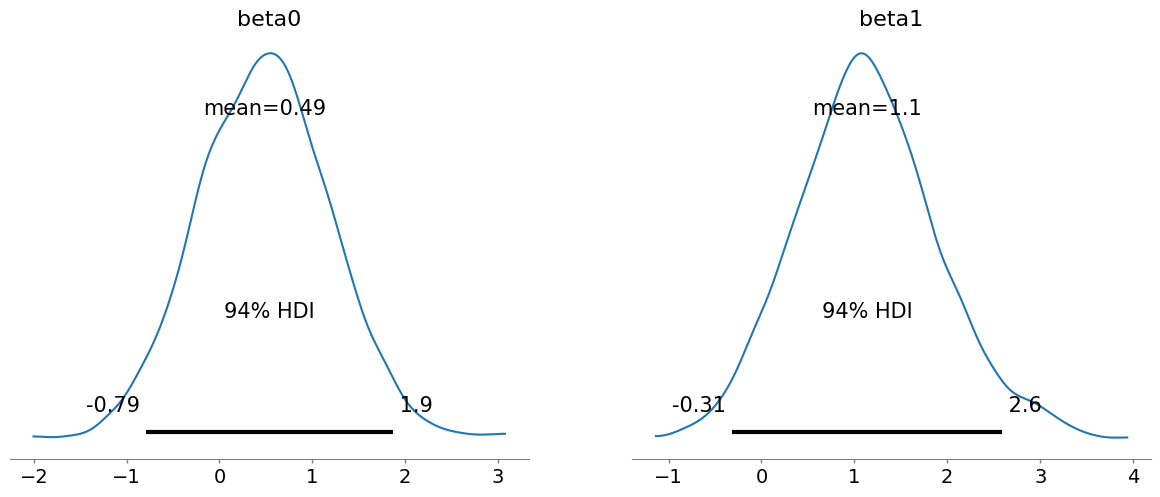

Frontiera de decizie medie: 6.31 ore
Interval HDI 94% pentru frontiera: [-6.46257315 10.26885159]


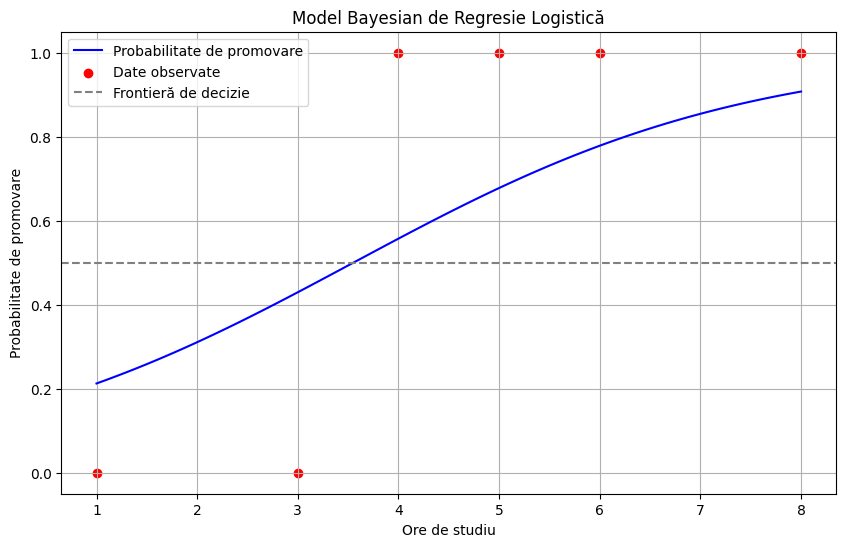

In [16]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

study_hours = np.array([1, 3, 4, 5, 6, 8])
passed_exam = np.array([0, 0, 1, 1, 1, 1])

study_hours_scaled = (study_hours - study_hours.mean()) / study_hours.std()

with pm.Model() as exam_model:
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)

    logit_p = beta0 + beta1 * study_hours_scaled
    p = pm.math.sigmoid(logit_p)

    y_obs = pm.Bernoulli("y_obs", p=p, observed=passed_exam)

    trace = pm.sample(2000, target_accept=0.95, return_inferencedata=True, cores=2)

az.plot_posterior(trace, var_names=["beta0", "beta1"])
plt.show()

beta0_samples = trace.posterior["beta0"].values.flatten()
beta1_samples = trace.posterior["beta1"].values.flatten()

study_hours_boundary = -beta0_samples / beta1_samples

study_hours_boundary_original = study_hours.mean() + study_hours.std() * study_hours_boundary

hdi_boundary = az.hdi(study_hours_boundary_original, hdi_prob=0.94)
print(f"Frontiera de decizie medie: {np.mean(study_hours_boundary_original):.2f} ore")
print(f"Interval HDI 94% pentru frontiera: {hdi_boundary}")

plt.figure(figsize=(10, 6))
study_hours_range = np.linspace(min(study_hours), max(study_hours), 100)

probabilities = 1 / (1 + np.exp(-(np.mean(beta0_samples) + np.mean(beta1_samples) *
                                (study_hours_range - study_hours.mean()) / study_hours.std())))

plt.plot(study_hours_range, probabilities, label="Probabilitate de promovare", color="blue")
plt.scatter(study_hours, passed_exam, color="red", label="Date observate")
plt.axhline(0.5, color="gray", linestyle="--", label="Frontieră de decizie")
plt.xlabel("Ore de studiu")
plt.ylabel("Probabilitate de promovare")
plt.title("Model Bayesian de Regresie Logistică")
plt.legend()
plt.grid()
plt.show()


Output()

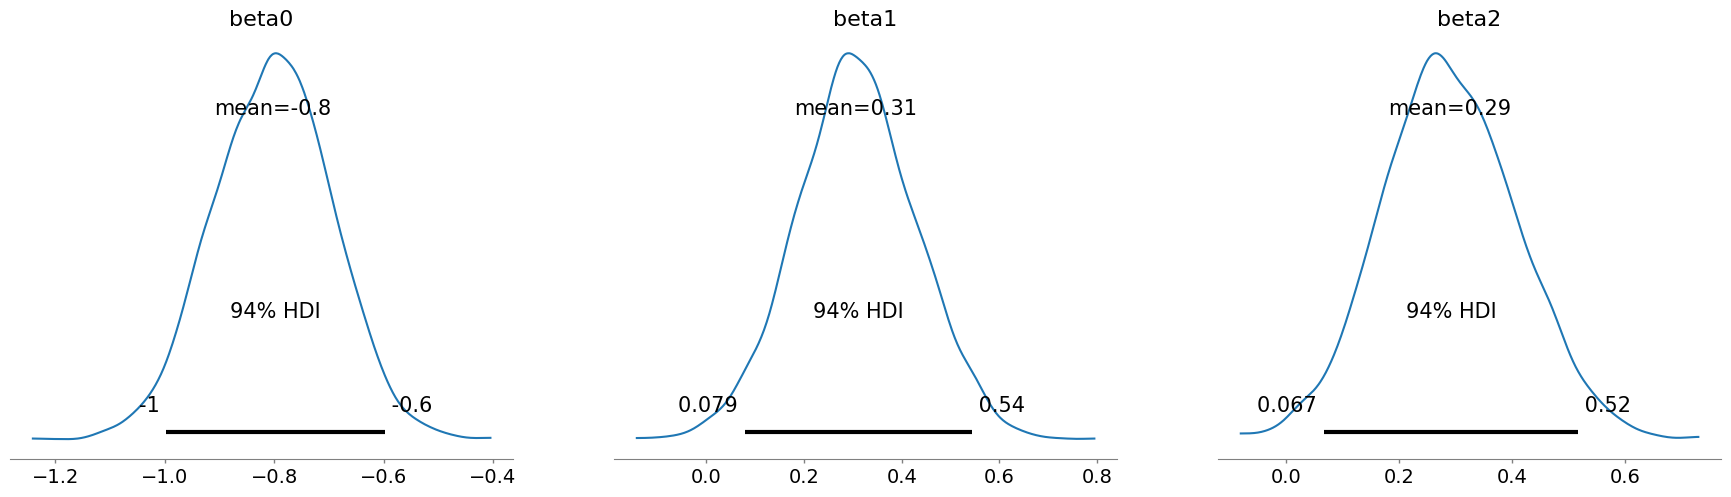

Frontiera medie pentru GRE la GPA=3.5 (rescalată invers): 957.22
Interval HDI 94% pentru frontiera (spațiul original): [ 697.65663913 1298.65766773]
Probabilitatea medie de admitere pentru GRE=550 si GPA=3.5: 0.31
Interval HDI 90%: [0.26358282 0.35046289]
Probabilitatea medie de admitere pentru GRE=500 si GPA=3.2: 0.24
Interval HDI 90%: [0.19337674 0.28209815]


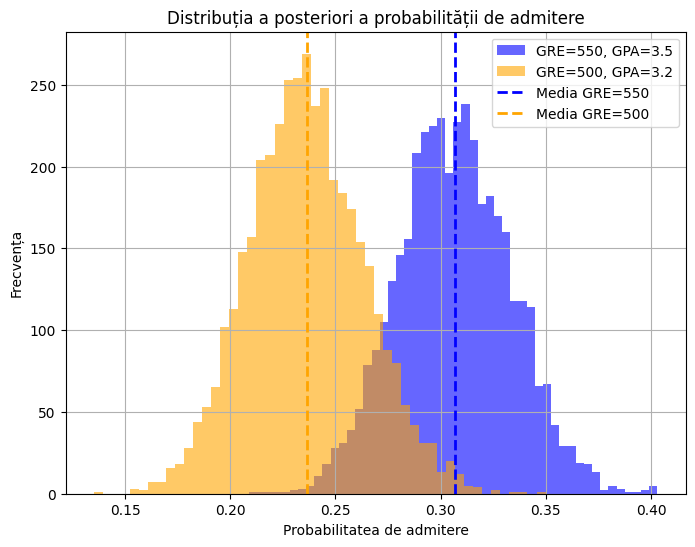

Media probabilității pentru GRE=550, GPA=3.5: 0.31
Media probabilității pentru GRE=500, GPA=3.2: 0.24


In [12]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from scipy.special import expit

data = pd.read_csv('Admission.csv')

x_GRE = (data['GRE'] - data['GRE'].mean()) / data['GRE'].std()
x_GPA = (data['GPA'] - data['GPA'].mean()) / data['GPA'].std()
y_admission = data['Admission'].values

with pm.Model() as admission_model:
    beta0 = pm.Normal('beta0', mu=0, sigma=1)
    beta1 = pm.Normal('beta1', mu=0, sigma=1)
    beta2 = pm.Normal('beta2', mu=0, sigma=1)

    logit_p = beta0 + beta1 * x_GRE + beta2 * x_GPA
    p = pm.math.sigmoid(logit_p)

    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_admission)

    trace = pm.sample(2000, target_accept=0.95, return_inferencedata=True, cores=2)

az.plot_posterior(trace, var_names=['beta0', 'beta1', 'beta2'])
plt.show()

beta0_samples = trace.posterior['beta0'].values.flatten()
beta1_samples = trace.posterior['beta1'].values.flatten()
beta2_samples = trace.posterior['beta2'].values.flatten()

GPA_fixed = (3.5 - data['GPA'].mean()) / data['GPA'].std()
gre_boundary_rescaled = - (beta0_samples + beta2_samples * GPA_fixed) / beta1_samples

gre_boundary_original = gre_boundary_rescaled * data['GRE'].std() + data['GRE'].mean()

hdi_boundary_original = az.hdi(gre_boundary_original, hdi_prob=0.94)

print(f"Frontiera medie pentru GRE la GPA=3.5 : {np.mean(gre_boundary_original):.2f}")
print(f"Interval HDI 94% pentru frontiera (spațiul original): {hdi_boundary_original}")


def predict_admission(gre, gpa, beta0, beta1, beta2):
    gre_scaled = (gre - data['GRE'].mean()) / data['GRE'].std()
    gpa_scaled = (gpa - data['GPA'].mean()) / data['GPA'].std()
    logit = beta0 + beta1 * gre_scaled + beta2 * gpa_scaled
    return expit(logit)


GRE_new1, GPA_new1 = 550, 3.5
prob_samples1 = predict_admission(GRE_new1, GPA_new1, beta0_samples, beta1_samples, beta2_samples)
prob_hdi1 = az.hdi(prob_samples1, hdi_prob=0.90)
print(f"Probabilitatea medie de admitere pentru GRE=550 si GPA=3.5: {np.mean(prob_samples1):.2f}")
print(f"Interval HDI 90%: {prob_hdi1}")


GRE_new2, GPA_new2 = 500, 3.2
prob_samples2 = predict_admission(GRE_new2, GPA_new2, beta0_samples, beta1_samples, beta2_samples)
prob_hdi2 = az.hdi(prob_samples2, hdi_prob=0.90)
print(f"Probabilitatea medie de admitere pentru GRE=500 si GPA=3.2: {np.mean(prob_samples2):.2f}")
print(f"Interval HDI 90%: {prob_hdi2}")

plt.figure(figsize=(8, 6))

plt.hist(prob_samples1, bins=50, alpha=0.6, color='blue', label='GRE=550, GPA=3.5')

plt.hist(prob_samples2, bins=50, alpha=0.6, color='orange', label='GRE=500, GPA=3.2')

plt.axvline(np.mean(prob_samples1), color='blue', linestyle='--', linewidth=2, label='Media GRE=550')
plt.axvline(np.mean(prob_samples2), color='orange', linestyle='--', linewidth=2, label='Media GRE=500')

plt.title("Distribuția a posteriori a probabilității de admitere")
plt.xlabel("Probabilitatea de admitere")
plt.ylabel("Frecvența")
plt.legend()
plt.grid()
plt.show()

mean_prob1 = np.mean(prob_samples1)
mean_prob2 = np.mean(prob_samples2)

print(f"Media probabilității pentru GRE=550, GPA=3.5: {mean_prob1:.2f}")
print(f"Media probabilității pentru GRE=500, GPA=3.2: {mean_prob2:.2f}")
